In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import os
import cv2
import tensorflow as tf


SEED = 42

2023-10-12 16:39:42.864640: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-12 16:39:42.914667: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-12 16:39:42.915692: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 16:39:43.733752: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
BASE_PATH = os.getcwd()
DATA_PATH = os.path.join(BASE_PATH, 'Data/AD')

In [3]:
BASE_PATH, DATA_PATH

('/home/dhakal/CapsNetAD', '/home/dhakal/CapsNetAD/Data/AD')

In [4]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(os.path.join(DATA_PATH, 'train'),
                                                                    validation_split=0.2,
                                                                    subset='training',
                                                                    seed=SEED,
                                                                    image_size=(160, 160),
                                                                    batch_size=32,
                                                                    shuffle=True
                                                                    )
test_data = tf.keras.preprocessing.image_dataset_from_directory(os.path.join(DATA_PATH, 'test'),
                                                                    validation_split=0.2,
                                                                    subset='validation',
                                                                    seed=SEED,
                                                                    image_size=(160, 160),
                                                                    batch_size=32,
                                                                    shuffle=True
                                                                    )

Found 11521 files belonging to 4 classes.
Using 9217 files for training.
Found 1279 files belonging to 4 classes.
Using 255 files for validation.


2023-10-12 16:39:45.048404: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
print(f"total train data per batch: {len(train_data)}")
print(f"total validation data per batch: {len(test_data)}")

total train data per batch: 289
total validation data per batch: 8


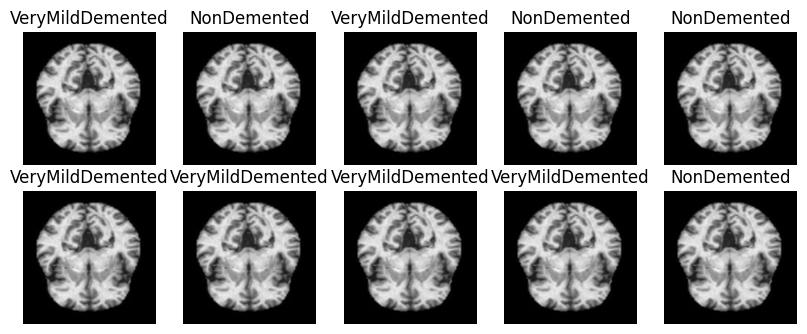

In [6]:
# set variable for class_names
class_names = train_data.class_names

# plot the train_data image
plt.figure(figsize=(10,10))
for images, labels in train_data.take(1):
  for i in range(10):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(images[1].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [7]:
# perform split of validation data into test data
val_batches = tf.data.experimental.cardinality(test_data)
val_data = test_data.skip(val_batches//2)
test_data = test_data.take(val_batches//2)

In [8]:
print(f"Number of validation batches: {tf.data.experimental.cardinality(val_data)}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_data)}")

Number of validation batches: 4
Number of test batches: 4


In [9]:
print(f"total train data: {len(train_data)}")
print(f"total validation data: {len(val_data)}")
print(f"total test data: {len(test_data)}")

total train data: 289
total validation data: 4
total test data: 4


In [10]:
# create prefetch dataset for better performance
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.prefetch(buffer_size = AUTOTUNE)
val_data = val_data.prefetch(buffer_size = AUTOTUNE)
test_data = test_data.prefetch(buffer_size = AUTOTUNE)

In [11]:
# preprocess image input to rescale the image to fit into the pre-trained model
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [12]:
IMG_SHAPE = (160, 160) + (3,)
base_model = tf.keras.applications.VGG16(input_shape = IMG_SHAPE,
                                         include_top = False,
                                         weights = 'imagenet'
                                         )

In [13]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

In [14]:
# Freeze the entire base_model
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

In [15]:
# set variable for classfier layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# set variable for output layer
nClass = len(class_names)
prediction_layer = tf.keras.layers.Dense(nClass, activation = 'softmax')

In [16]:
# re-construct the model
inputs = tf.keras.Input(shape = (160,160,3))
x = preprocess_input(inputs)
x = base_model(x, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
# compile the model
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy']
              )

In [18]:
# check the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 160, 160, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 160, 160, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                             

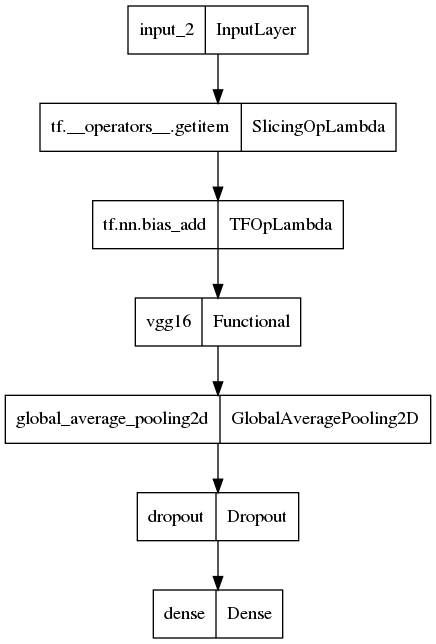

In [19]:
tf.keras.utils.plot_model(model)

In [20]:
loss0, accuracy0 = model.evaluate(val_data)

print("---------------------------------------------Before Training---------------------------------------------")
print("loss", loss0)
print("accuracy", accuracy0)

4/4 [==============================] - 3s 554ms/step - loss: 8.8513 - accuracy: 0.0315
---------------------------------------------Before Training---------------------------------------------
loss 8.851316452026367
accuracy 0.031496062874794006


In [21]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
from gc import callbacks
import datetime, os
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
es_callback = callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 2)

In [22]:
# start train the model
initial_epochs = 50 
history = model.fit(train_data,
                    epochs = initial_epochs,
                    validation_data = val_data,
                    callbacks = [tensorboard_callback, es_callback])

Epoch 1/50
289/289 [==============================] - 154s 531ms/step - loss: 4.2443 - accuracy: 0.3209 - val_loss: 1.8131 - val_accuracy: 0.5039
Epoch 2/50
289/289 [==============================] - 154s 533ms/step - loss: 2.8097 - accuracy: 0.4166 - val_loss: 1.7066 - val_accuracy: 0.5276
Epoch 3/50
289/289 [==============================] - 153s 530ms/step - loss: 2.4776 - accuracy: 0.4331 - val_loss: 1.5086 - val_accuracy: 0.5039
Epoch 4/50
289/289 [==============================] - 153s 528ms/step - loss: 2.1872 - accuracy: 0.4480 - val_loss: 1.4050 - val_accuracy: 0.5197
Epoch 5/50
289/289 [==============================] - 154s 533ms/step - loss: 1.9913 - accuracy: 0.4494 - val_loss: 1.3314 - val_accuracy: 0.4961
Epoch 6/50
289/289 [==============================] - 153s 529ms/step - loss: 1.7657 - accuracy: 0.4729 - val_loss: 1.1756 - val_accuracy: 0.5433
Epoch 7/50
289/289 [==============================] - 156s 540ms/step - loss: 1.6135 - accuracy: 0.4814 - val_loss: 1.0376 -

In [23]:
%tensorboard --logdir logs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-10-12 18:15:12.672841: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-12 18:15:12.721906: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-12 18:15:12.722460: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 18:15:13.418133: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-12 18:15:14.303703: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to u

In [24]:
base_model.trainable = True

In [25]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [26]:
# So, we are going to fine-tune 10 layers ahead
fine_tune_at = 10

# Freeze all the layer before "fine_tune_at" layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [27]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate = base_learning_rate/10),
              metrics = ['accuracy'])

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 160, 160, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 160, 160, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                             

In [29]:
# Now, we resume the model trianing from the last epochs
fine_tune_epochs = 50
total_epochs = initial_epochs + fine_tune_epochs

# train the model again
histroy_fine_tune = model.fit(train_data,
                              epochs = total_epochs,
                              initial_epoch = history.epoch[-1],
                              validation_data = val_data,
                              callbacks = [tensorboard_callback, es_callback])

Epoch 37/100
289/289 [==============================] - 304s 1s/step - loss: 0.6758 - accuracy: 0.7091 - val_loss: 0.5876 - val_accuracy: 0.7795
Epoch 38/100
289/289 [==============================] - 302s 1s/step - loss: 0.3686 - accuracy: 0.8541 - val_loss: 0.6738 - val_accuracy: 0.6929
Epoch 39/100
289/289 [==============================] - 305s 1s/step - loss: 0.2049 - accuracy: 0.9243 - val_loss: 0.2578 - val_accuracy: 0.9134
Epoch 40/100
289/289 [==============================] - 342s 1s/step - loss: 0.1198 - accuracy: 0.9587 - val_loss: 0.2459 - val_accuracy: 0.9055
Epoch 41/100
289/289 [==============================] - 805s 3s/step - loss: 0.0806 - accuracy: 0.9711 - val_loss: 0.3009 - val_accuracy: 0.9055
Epoch 42/100
289/289 [==============================] - 304s 1s/step - loss: 0.0628 - accuracy: 0.9788 - val_loss: 0.0945 - val_accuracy: 0.9685
Epoch 43/100
289/289 [==============================] - 300s 1s/step - loss: 0.0424 - accuracy: 0.9859 - val_loss: 0.4615 - val_ac

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [30]:
%tensorboard --logdir logs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-10-12 19:49:07.205732: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-12 19:49:07.252045: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-12 19:49:07.252626: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 19:49:07.918342: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-12 19:49:08.805559: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to u

In [31]:
# Evaluate the model
print("-----------------------------------After Fine-tuning model..........................................")
model.evaluate(test_data)

-----------------------------------After Fine-tuning model..........................................
4/4 [==============================] - 2s 529ms/step - loss: 0.0276 - accuracy: 0.9844


[0.027637183666229248, 0.984375]

In [32]:
image_batch, label_batch = test_data.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
class_predictions = np.argmax(predictions, axis=1)

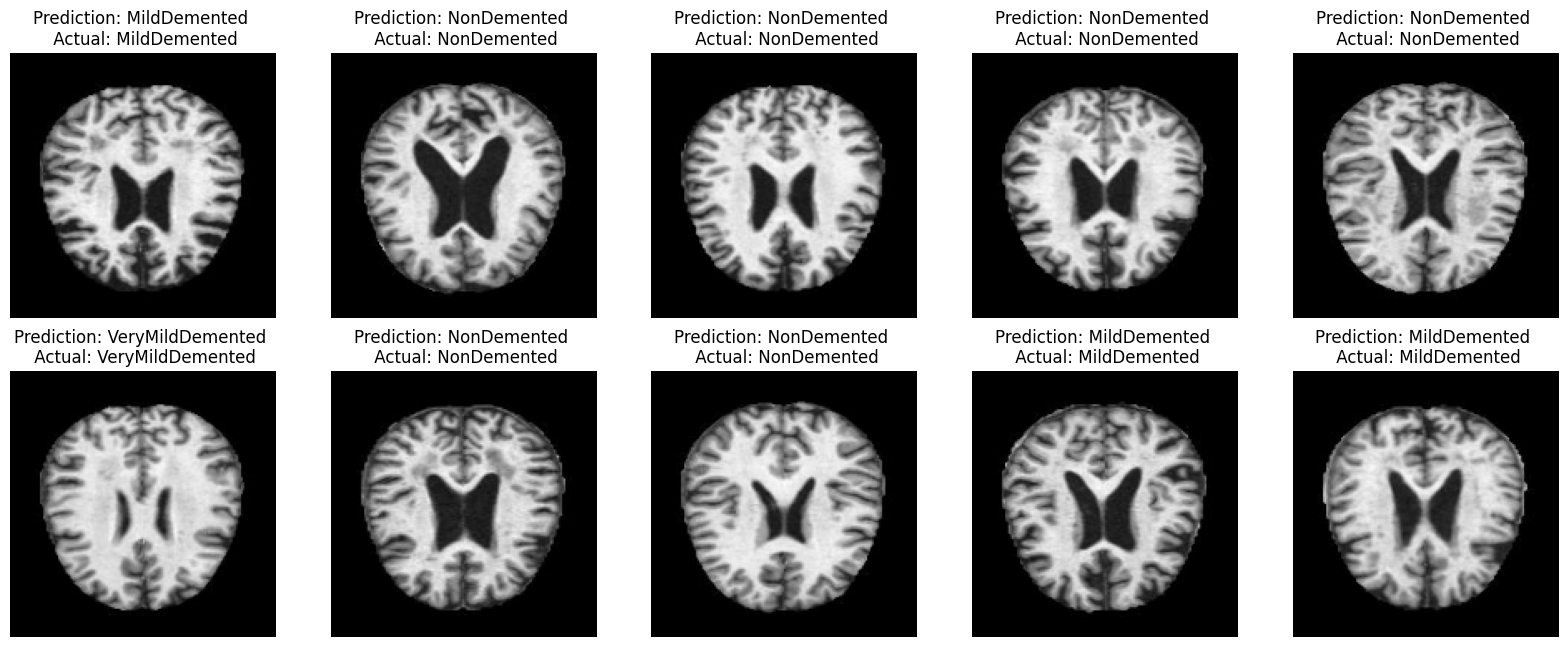

In [33]:
# plot the prediction vs actual label
plt.figure(figsize = (20,20))
for i in range(10):
  axs = plt.subplot(5,5,i+1)
  plt.imshow(image_batch[i].astype("uint8"))
  current_prediction = class_names[class_predictions[i]]
  current_label = class_names[label_batch[i]]
  plt.title(f"Prediction: {current_prediction} \n Actual: {current_label}")
  plt.axis('off')